In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.nn.functional as F

mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = ["Times", "Times New Roman", "DejaVu Serif"]


In [2]:
X_raw = torch.tensor([[1.0], [3.0], [5.0]])
y_train = torch.tensor([[15.0], [50.0], [82.0]])

# Normalize input
# Chuẩn hoá dữ liệu đầu vào để tránh hiện tượng các nơ-ron nhanh chóng bão hoà
mean_x = 3.0
std_x = 2.0
X_train = (X_raw - mean_x) / std_x

print(f"X_train (normalized):\n {X_train}")

X_train (normalized):
 tensor([[-1.],
        [ 0.],
        [ 1.]])


In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(
            1, 2
        )  # đầu vào vô hướng (=1), đầu ra là hidden1 có 2 nơ ron
        self.fc2 = nn.Linear(
            2, 2
        )  # đầu vào là hidden1 có 2 nơ ron, đầu ra là hidden2 có 2 nơ ron
        self.fc3 = nn.Linear(
            2, 1
        )  # đầu vào là hidden2 có 2 nơ ron, đầu ra là tuyến tính (=1)

    def forward(self, x):
        z1 = self.fc1(x)
        a1 = F.relu(z1)

        z2 = self.fc2(a1)
        a2 = F.relu(z2)

        y_hat = self.fc3(a2)
        return y_hat


model = SimpleMLP()

with torch.no_grad():
    # Layer 1(w1, b1)
    model.fc1.weight.copy_(torch.tensor([[0.4967], [-0.1383]]))
    model.fc1.bias.copy_(torch.tensor([0.6477, 1.5230]))

    # Layer 2 (w2, b2)
    model.fc2.weight.copy_(torch.tensor([[-0.2342, -0.2341], [-0.2341, -0.2342]]))
    model.fc2.bias.copy_(torch.tensor([1.5792, 0.7674]))

    # Layer 3 (w3, b3)
    model.fc3.weight.copy_(torch.tensor([[-0.4695, 0.5426]]))
    model.fc3.bias.copy_(torch.tensor([0.0]))

num_params = sum(p.numel() for p in model.parameters())
print(f"Tổng tham số cần có = {num_params}")

Tổng tham số cần có = 13


In [4]:
x_test_raw = 6.0
x_test_norm = torch.tensor([[(x_test_raw - mean_x) / std_x]])

with torch.no_grad():
    y_hat_init = model(x_test_norm)
    y_true_assumed = 88.0
    sq_error_init = (y_true_assumed - y_hat_init.item()) ** 2

print(f"Input chuẩn hóa: {x_test_norm.item()}")
print(f"Dự đoán (y_hat): {y_hat_init.item():.4f}")
print(f"Sai số bình phương (y=88): {sq_error_init:.2f}")

Input chuẩn hóa: 1.5
Dự đoán (y_hat): -0.3714
Sai số bình phương (y=88): 7809.50


In [ ]:
# train
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

NUM_EPOCHS = 10
loss_history = []

model.train()
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0.0
    for i in range(len(X_train)):
        xi = X_train[i : i + 1]
        yi = y_train[i : i + 1]

        y_pred = model(xi)
        loss = criterion(y_pred, yi)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(X_train)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch + 1}: Avg Loss = {avg_loss:.2f}")


Epoch 1: Avg Loss = 3153.59
Epoch 2: Avg Loss = 3043.70
Epoch 3: Avg Loss = 2870.35
Epoch 4: Avg Loss = 2457.67
Epoch 5: Avg Loss = 1382.43
Epoch 6: Avg Loss = 302.84
Epoch 7: Avg Loss = 109.46
Epoch 8: Avg Loss = 19.75
Epoch 9: Avg Loss = 8.78
Epoch 10: Avg Loss = 9.64


In [7]:
# Dự đoán sau train
model.eval()
with torch.no_grad():
    y_hat_final = model(x_test_norm)
print(y_hat_final)

tensor([[96.1046]])


In [8]:
# Tính R2 score
with torch.no_grad():
    y_preds = model(X_train)
    r2 = r2_score(y_train, y_preds)

print(r2)

0.992608904838562


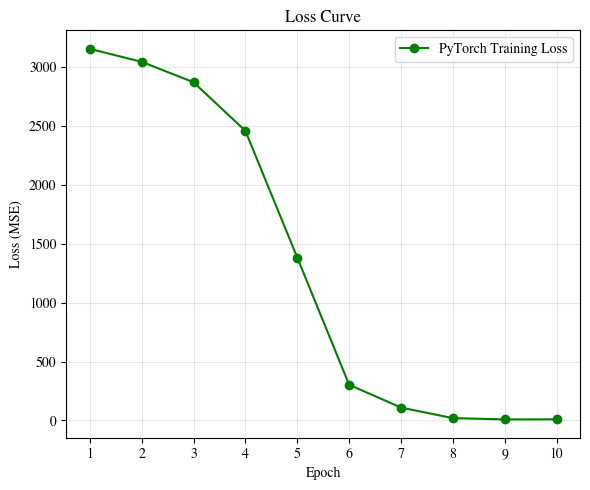

In [ ]:
plt.figure(figsize=(6, 5))
plt.plot(
    range(1, NUM_EPOCHS + 1),
    loss_history,
    marker="o",
    color="green",
    label="PyTorch Training Loss",
)
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Loss Curve")
plt.grid(alpha=0.3)
plt.xticks(range(1, NUM_EPOCHS + 1))
plt.legend()
plt.tight_layout()
plt.show()